In [7]:
from __future__ import print_function
from csky.ipyconfig import *
from csky import bk, analysis, coord, dists, hyp, inj, llh, pdf, selections, trial, utils
import csky as cy
import histlite as hl
import healpy as hp
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
#from icecube import astro

mp_cpus = 20

In [2]:
ana_dir = utils.ensure_dir ('/data/user/drysewyk/csky_cache/ana_new')
repo = selections.mrichman_repo

In [3]:
ana7 = analysis.Analysis (repo, selections.PSDataSpecs.ps_7yr, dir=ana_dir)

Setting up Analysis for:
IC40, IC59, IC79, IC86_2011, IC86_2012_2014
Setting up IC40...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC40_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC40_exp.npy ...
<- /data/user/drysewyk/csky_cache/ana_new/IC40.subanalysis.npy    
Setting up IC59...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC59_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC59_exp.npy ...
<- /data/user/drysewyk/csky_cache/ana_new/IC59.subanalysis.npy    
Setting up IC79...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC79_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC79_exp.npy ...
<- /data/user/drysewyk/csky_cache/ana_new/IC79.subanalysis.npy    
Setting up IC86_2011...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC86_2011_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC86_2011_exp.npy ...
<- /data/user/drysewyk/csky

In [10]:
mrichman_mpl ()

In [5]:
def get_llh (a, src, sigsub):
    # space PDF - use default background space PDF and signal acceptance parameterization
    space_model = pdf.PointSourceSpacePDFRatioModel ( a, src, a.bg_space_param, a.acc_param, sigsub=sigsub )
    # energy PDF - use default parameterization
    energy_model = a.energy_pdf_ratio_model
    # put it together
    pdf_ratio_model = pdf.MultiPDFRatioModel (space_model, energy_model)
    N = len (a.data)
    llh_model = llh.LLHModel (pdf_ratio_model, N, sigsub=sigsub)
    return llh_model

def get_injs (a, llh_model, src, flux, cut_n_sigma, inj):
    # note which event features we need
    keep = llh_model.pdf_ratio_model.keep
    # optimization: dec band cut
    selector = cy.inj.DecBandSelector (src, cut_n_sigma=cut_n_sigma)
    # truth: unscrambled data, for unblinding
    truth = cy.inj.DataInjector (a, selector (a.data), keep, randomizers=[])
    # bg: scrambled data
    randomizers = [cy.inj.RARandomizer ()]#, cy.inj.DecRandomizer()]#, cy.inj.PoleRandomizer (np.radians (30))]
    bg = cy.inj.DataInjector (a, selector (a.data), keep, randomizers=randomizers)
    # sig: signal injection
    sig = cy.inj.PointSourceInjector (a, src, flux, keep) if inj else None
    return truth, bg, sig

def get_tr (src, ana=ana7, flux=hyp.PowerLawFlux (2), inj=True, use_energy=True, cut_n_sigma=5, sigsub=False, _fit_null=True, mp_cpus=mp_cpus):
    # get_llh needs the src list
    llh_kw = dict (src=src, sigsub=sigsub)
    # get_injs needs the src list and signal spectrum
    inj_kw = dict (src=src, flux=flux, cut_n_sigma=cut_n_sigma, inj=inj)
    # trial.get_trial_runner loops over sub analyses and gives a single TrialRunner
    return trial.get_trial_runner (
        ana, get_llh, get_injs, llh_kw=llh_kw, inj_kw=inj_kw, mp_cpus=mp_cpus)


def get_getters (ana=ana7, extension=0, cut_n_sigma=3, sigsub=False):
    def get_tr_skymap (src=None, cut_n_sigma=3, _fit_null=True, inj=True):
        if src is None:
            src = utils.Sources (ra=0, dec=0, extension=extension)
        src['extension'] = extension * np.ones_like (src.dec)
        return get_tr (src, ana=ana, cut_n_sigma=cut_n_sigma, sigsub=sigsub, _fit_null=_fit_null, inj=inj)
    def get_selector (dec):
        return inj.DecBandSelector (utils.Sources (dec=dec, extension=extension))
    return get_tr_skymap, get_selector

def plot_result (v, clabel, title='', vmin=None, vmax=None, cmap='viridis', projection='aitoff'):
    if vmin is None:
        vmin = 0
    if vmax is None:
        vmax = np.ceil (v.max())
    fig, ax = plt.subplots (figsize=(8,6), subplot_kw=dict (projection=projection))
    sp = csp.SkyPlotter (pc_kw=dict (cmap=cmap, vmin=vmin, vmax=vmax))
    v = hp.ud_grade (v, 256)
    mesh, cb = sp.plot_map (ax, v, n_ticks=2, titleticks=bool (title))
    sp.plot_gp (ax, color='.5', lw=.5, alpha=.25)
    ax.grid (alpha=.5, ls='-')
    cb.set_label (clabel)
    ax.set_title (title)
    plt.tight_layout()
    return fig, ax

In [6]:
src_1 = cy.utils.Sources (ra=0, dec=0, extension=np.radians (1))
src_2 = cy.utils.Sources (ra=0, dec=0, extension=np.radians (2))
src_3 = cy.utils.Sources (ra=0, dec=0, extension=np.radians (3))
src_4 = cy.utils.Sources (ra=0, dec=0, extension=np.radians (4))
src_5 = cy.utils.Sources (ra=0, dec=0, extension=np.radians (5))

tr_1 = get_tr (src_1, ana7)
tr_2 = get_tr (src_2, ana7)
tr_3 = get_tr (src_3, ana7)
tr_4 = get_tr (src_4, ana7)
tr_5 = get_tr (src_5, ana7)
tr_5_ss = get_tr (src_5, ana7, sigsub=True)

In [20]:
bg_5_10 = cy.dists.Chi2TSD (tr_5.get_many_fits (10000))

Performing 10000 background trials using 15 cores:
      10000/10000 trials complete.   


In [7]:
%time bg_5_500_ss = cy.dists.Chi2TSD (tr_5_ss.get_many_fits (500))

Performing 500 background trials using 15 cores:
        500/500 trials complete.   
CPU times: user 262 ms, sys: 437 ms, total: 699 ms
Wall time: 1min 14s


In [9]:
%time bg_5_5000_ss = cy.dists.Chi2TSD (tr_5_ss.get_many_fits (5000))

Performing 5000 background trials using 15 cores:
       5000/5000 trials complete.   
CPU times: user 1.8 s, sys: 675 ms, total: 2.48 s
Wall time: 11min 38s


In [8]:
%time bg_5_10000_ss = cy.dists.Chi2TSD (tr_5_ss.get_many_fits (10000))

Performing 10000 background trials using 15 cores:
      10000/10000 trials complete.   
CPU times: user 3.61 s, sys: 906 ms, total: 4.52 s
Wall time: 23min 9s


In [17]:
%time bg_1 = cy.dists.Chi2TSD (tr_1.get_many_fits (50000))
#np.save('Background/bg_1_50000fits.npy',bg_1)
%time bg_2 = cy.dists.Chi2TSD (tr_2.get_many_fits (50000))
#np.save('Background/bg_2_50000fits.npy',bg_2)
%time bg_3 = cy.dists.Chi2TSD (tr_3.get_many_fits (50000))
#np.save('Background/bg_3_50000fits.npy',bg_3)
%time bg_4 = cy.dists.Chi2TSD (tr_4.get_many_fits (50000))
#np.save('Background/bg_4_50000fits.npy',bg_4)
%time bg_5 = cy.dists.Chi2TSD (tr_5.get_many_fits (50000))
#np.save('Background/bg_5_50000fits.npy',bg_5)

Performing 50000 background trials using 15 cores:
      50000/50000 trials complete.   
CPU times: user 1.81 s, sys: 634 ms, total: 2.45 s
Wall time: 5min 47s
Performing 50000 background trials using 15 cores:
      50000/50000 trials complete.   
CPU times: user 2.49 s, sys: 680 ms, total: 3.17 s
Wall time: 8min 59s
Performing 50000 background trials using 15 cores:
      50000/50000 trials complete.   
CPU times: user 4.23 s, sys: 1.18 s, total: 5.41 s
Wall time: 18min 18s
Performing 50000 background trials using 15 cores:
        641/50000 trials complete...
KeyboardInterrupt: terminating early.
        674/50000 trials complete.   
CPU times: user 248 ms, sys: 811 ms, total: 1.06 s
Wall time: 23.5 s
Performing 50000 background trials using 15 cores:
       1723/50000 trials complete...
KeyboardInterrupt: terminating early.
       1772/50000 trials complete.   
CPU times: user 269 ms, sys: 770 ms, total: 1.04 s
Wall time: 1min 10s


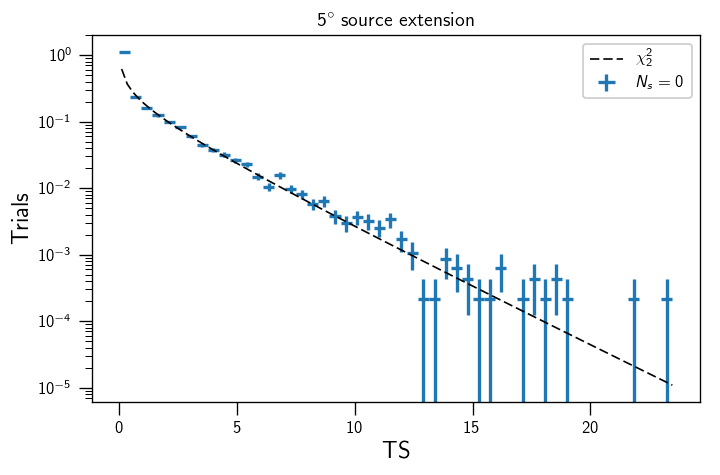

In [12]:
fig, ax = plt.subplots ()
h = bg_5_10000_ss.get_hist (bins=50)
hl.plot1d (ax, h.normalize (), label=r'$N_{s}=0$', crosses=True)
x = np.linspace (.1, h.range[0][-1], 100)
ax.semilogy (x, bg_5_10000_ss.eta * bg_5_10000_ss.chi2.pdf (x), 'k--', lw=1, label=r'$\chi_{2}^{2}$')
plt.xlabel(r'TS',fontsize=14)
plt.ylabel('Trials',fontsize=14)
#plt.ylim(0,30)
plt.title(r'$5^{\circ}$ source extension')
plt.legend()
plt.tight_layout ()
ax.tick_params(axis='both',which='major',length=8,labelsize=10)
ax.tick_params(axis='both',which='minor',length=4)
ax.semilogy(nonposy='clip')
plt.savefig('/data/user/drysewyk/llh_sandbox/Plots/Back_TS_Dist_5deg.png')

In [19]:
dec_array = np.linspace(-0.9,0.9,10)

sens_1 = np.load('Sensitivity/sens_1.npy')
sens_2 = np.load('Sensitivity/sens_2.npy')
sens_3 = np.load('Sensitivity/sens_3.npy')
sens_4 = np.load('Sensitivity/sens_4.npy')
sens_5 = np.load('Sensitivity/sens_5.npy')

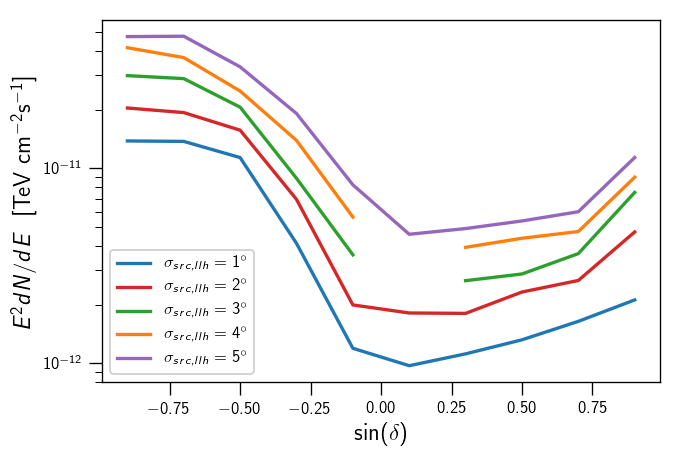

In [40]:
fig, ax = plt.subplots ()
plt.semilogy(dec_array,sens_1,label=r'$\sigma_{src,llh}=1^{\circ}$')
plt.semilogy(dec_array,sens_2,label=r'$\sigma_{src,llh}=2^{\circ}$')
plt.semilogy(dec_array,sens_3,label=r'$\sigma_{src,llh}=3^{\circ}$')
plt.semilogy(dec_array,sens_4,label=r'$\sigma_{src,llh}=4^{\circ}$')
plt.semilogy(dec_array,sens_5,label=r'$\sigma_{src,llh}=5^{\circ}$')
plt.legend(loc='lower left')
ax.tick_params(axis='both',which='major',length=8,labelsize=10)
ax.tick_params(axis='both',which='minor',length=4)
plt.xlabel(r'$\sin (\delta)$', fontsize=14)
plt.ylabel(r'$E^{2} dN/dE \ \  [\mathrm{TeV} \ \mathrm{cm}^{-2}\mathrm{s}^{-1}]$',fontsize=14)